## Importing necessary files

In [ ]:
import tarfile
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
from astropy.io import fits

import tensorflow as tf
import keras
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, ReLU, UpSampling2D, Input, Flatten
from keras import Model, Sequential
from keras.layers import Dense, Dropout
from keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
!gdown 1eXmbZqUfpqhI-MWz2xkpK0dXQ4FttGQf

Downloading...
From: https://drive.google.com/uc?id=1eXmbZqUfpqhI-MWz2xkpK0dXQ4FttGQf
To: /content/lens_finding.tgz
100% 699M/699M [00:18<00:00, 37.5MB/s]


### Extracting files from .tgz file

In [ ]:
# open file

file = tarfile.open('/content/lens_finding.tgz')
  
# extracting file
file.extractall('./data')
  
file.close()

### Reading the classifications.csv file

In [ ]:
df = pd.read_csv('./data/SpaceBasedTraining/classifications.csv', delimiter = ',')

In [ ]:
df.head()

,ID,is_lens,Einstein_area,numb_pix_lensed_image,flux_lensed_image_in_sigma
0,100000,1,8.633760e-10,171,195.429
1,100001,1,1.317890e-10,294,855.589
2,100002,1,4.877250e-12,140,486.113
3,100003,1,1.440160e-09,1500,10467.400
4,100004,0,2.197350e-11,0,0.000


In [ ]:
df['image_name'] = "imageEUC_VIS-" + df['ID'].astype(str) + '.fits'

In [ ]:
df['ID'].dtype

dtype('int64')

In [ ]:
df.head()

,ID,is_lens,Einstein_area,numb_pix_lensed_image,flux_lensed_image_in_sigma,image_name
0,100000,1,8.633760e-10,171,195.429,imageEUC_VIS-100000.fits
1,100001,1,1.317890e-10,294,855.589,imageEUC_VIS-100001.fits
2,100002,1,4.877250e-12,140,486.113,imageEUC_VIS-100002.fits
3,100003,1,1.440160e-09,1500,10467.400,imageEUC_VIS-100003.fits
4,100004,0,2.197350e-11,0,0.000,imageEUC_VIS-100004.fits


In [ ]:
!pwd

/content


In [ ]:
df['image_name']

0        imageEUC_VIS-100000.fits
1        imageEUC_VIS-100001.fits
2        imageEUC_VIS-100002.fits
3        imageEUC_VIS-100003.fits
4        imageEUC_VIS-100004.fits
                   ...           
17995    imageEUC_VIS-117995.fits
17996    imageEUC_VIS-117996.fits
17997    imageEUC_VIS-117997.fits
17998    imageEUC_VIS-117998.fits
17999    imageEUC_VIS-117999.fits
Name: image_name, Length: 18000, dtype: object

In [ ]:
p = pathlib.Path("./data/SpaceBasedTraining/files/")
l = list(p.glob("*"))

In [ ]:
l[:5]

[PosixPath('data/SpaceBasedTraining/files/imageEUC_VIS-117358.fits'),
 PosixPath('data/SpaceBasedTraining/files/imageEUC_VIS-109707.fits'),
 PosixPath('data/SpaceBasedTraining/files/imageEUC_VIS-116739.fits'),
 PosixPath('data/SpaceBasedTraining/files/imageEUC_VIS-116106.fits'),
 PosixPath('data/SpaceBasedTraining/files/imageEUC_VIS-110473.fits')]

## Reading a single .fits file

In [ ]:
file = fits.open('./data/SpaceBasedTraining/files/imageEUC_VIS-106200.fits')

In [ ]:
file.info()

Filename: ./data/SpaceBasedTraining/files/imageEUC_VIS-106200.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (101, 101)   float32   


In [ ]:
file[0]

In [ ]:
file[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  101 / length of data axis 1                          
NAXIS2  =                  101 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
WCSAXES =                    2 / number of World Coordinate System axes         
CRPIX1  =                  51. / x-coordinate of reference pixel                
CRPIX2  =                  51. / y-coordinate of reference pixel                
CRVAL1  =                   0. / first axis value at reference pixel            
CRVAL2  =                   

In [ ]:
file[0].data

array([[ 2.5818529e-13, -3.0978014e-13,  5.4756374e-14, ...,
         1.3944645e-12, -7.3494905e-13, -5.5180670e-13],
       [-8.4729229e-13,  1.0278223e-12,  4.7407651e-13, ...,
        -8.8183405e-13,  7.8237812e-13,  6.7317235e-13],
       [-3.0263137e-13, -2.6285571e-13, -1.0895730e-13, ...,
        -2.2051416e-13,  6.1281106e-14,  9.0410470e-13],
       ...,
       [ 9.7658719e-13, -7.9028770e-13,  2.8245467e-13, ...,
        -2.2840765e-13,  6.2207135e-13,  1.2004569e-12],
       [-7.7629813e-13,  2.5155499e-13,  3.6933327e-14, ...,
         1.2964281e-12, -5.9203797e-13,  1.3326074e-13],
       [ 1.5078253e-13, -5.1067326e-13, -7.0193695e-14, ...,
        -1.4773020e-12, -2.5534262e-13, -1.4769306e-12]], dtype=float32)

### Plots of a single image (normal, grayscale and lognorm) before applying min-max normalization

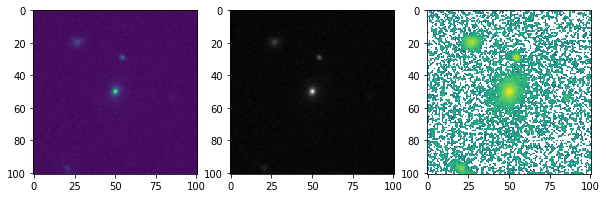

In [ ]:
plt.figure(figsize = (10, 15))
plt.subplot(1, 3, 1)
plt.imshow(file[0].data)

plt.subplot(1, 3, 2)
plt.imshow(file[0].data, cmap='gray')

plt.subplot(1, 3, 3)
plt.imshow(file[0].data, norm=LogNorm())

### Plots of a single image (normal, grayscale and lognorm) after applying min-max normalization

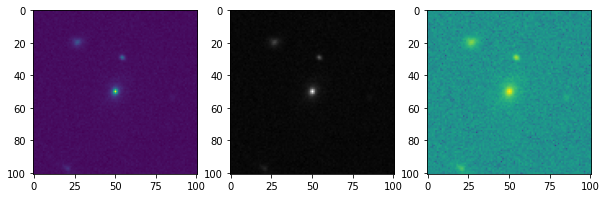

In [ ]:
img = file[0].data
img_minmax = (img-np.min(img))/(np.max(img)-np.min(img))

plt.figure(figsize = (10, 15))
plt.subplot(1, 3, 1)
plt.imshow(img_minmax)

plt.subplot(1, 3, 2)
plt.imshow(img_minmax, cmap='gray')

plt.subplot(1, 3, 3)
plt.imshow(img_minmax, norm=LogNorm())

In [ ]:
data = file[0].data

In [ ]:
data.shape

(101, 101)

In [ ]:
data.dtype.name

'float32'

In [ ]:
print('min: ', np.min(data))
print('max: ', np.max(data))
print('mean: ', np.mean(data))
print('stdev: ', np.std(data))

min:  -2.6145008e-12
max:  8.0568864e-11
mean:  2.97411e-13
stdev:  2.0697831e-12


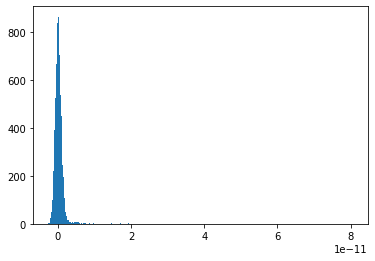

In [ ]:
histogram = plt.hist(data.flat, bins = 500)

## Loading image data and labels into a single array for training (and applying min-max normalization)

In [ ]:
import time

start = time.time()

len_images = len(df)
path = './data/SpaceBasedTraining/files/'

images = np.zeros((len_images, 101, 101, 1))
labels = np.zeros((len_images, 1))
for i in range(len_images):
    img = np.array(fits.open(path + df['image_name'][i])[0].data)
    img_minmax = (img-np.min(img))/(np.max(img)-np.min(img))
    label = df['is_lens'][i]
#     print(img[0].shape)
    img_expanded = np.expand_dims(img_minmax, axis = -1)
    images[i] = img_expanded
    labels[i] = label
#     print(i)

# print(images[0])
end = time.time()
print(end - start)

28.434258222579956


In [ ]:
images.shape

(18000, 101, 101, 1)

In [ ]:
labels = labels.astype(int)

In [ ]:
# labels = tf.keras.utils.to_categorical(labels)

In [ ]:
labels.shape

(18000, 1)

## CNN architecture and training

In [ ]:
input_img = Input(shape=(101, 101, 1))
x = Conv2D(4, (16, 16), activation='relu', padding='same')(input_img)
x = MaxPool2D((2, 2), padding='valid')(x)
x = Conv2D(8, (8, 8), activation='relu', padding='same')(x)
x = MaxPool2D((2, 2), padding='valid')(x)
# x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
# x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
x = Flatten()(x)
x = Dense(256, activation = 'relu')(x)
x = Dense(1, activation = 'sigmoid')(x)

model = Model(input_img, x)


model_earlystop = EarlyStopping(patience = 5, min_delta = 0.001, monitor = 'val_acc')

path = 'model_checkpoint/checkpoint_{epoch:02d}';
model_checkpoint = ModelCheckpoint(filepath = path,
                            verbose = 1,
                            monitor = 'val_acc',
                            save_freq = 'epoch',
                            save_best_only = True,
                            save_weights_only = True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.003), loss='binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 101, 101, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 101, 101, 4)       1028      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 8)         2056      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 8)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 5000)              0     

In [ ]:
history = model.fit(images, labels, validation_split = 0.2, batch_size = 32, shuffle = True, epochs = 10)

Epoch 1/10
450/450 [==============================] - 551s 1s/step - loss: 0.6161 - acc: 0.6978 - val_loss: 0.6121 - val_acc: 0.6994
Epoch 2/10
450/450 [==============================] - 537s 1s/step - loss: 0.6113 - acc: 0.6983 - val_loss: 0.6104 - val_acc: 0.6994
Epoch 3/10
450/450 [==============================] - 535s 1s/step - loss: 0.6108 - acc: 0.6983 - val_loss: 0.6093 - val_acc: 0.6994
Epoch 4/10
450/450 [==============================] - 525s 1s/step - loss: 0.6103 - acc: 0.6983 - val_loss: 0.6072 - val_acc: 0.6994
Epoch 5/10
450/450 [==============================] - 535s 1s/step - loss: 0.6081 - acc: 0.6983 - val_loss: 0.6096 - val_acc: 0.6994
Epoch 6/10
450/450 [==============================] - 526s 1s/step - loss: 0.6099 - acc: 0.6983 - val_loss: 0.6087 - val_acc: 0.6994
Epoch 7/10
355/450 [======================>.......] - ETA: 1:44 - loss: 0.6040 - acc: 0.7020

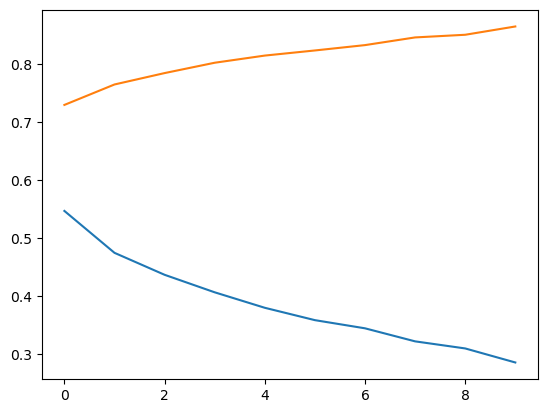

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['acc'])

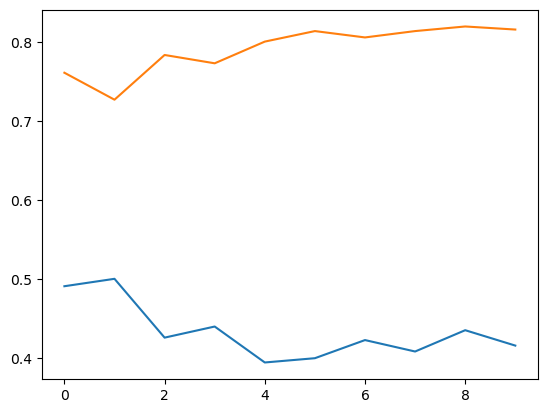

In [ ]:
plt.figure()
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_acc'])

### Plotting the final ROC curve and AUC score for whole data

In [ ]:
from sklearn.metrics import roc_curve
y_test = labels
y_pred_keras = model.predict(images).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

563/563 [==============================] - 52s 90ms/step


In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

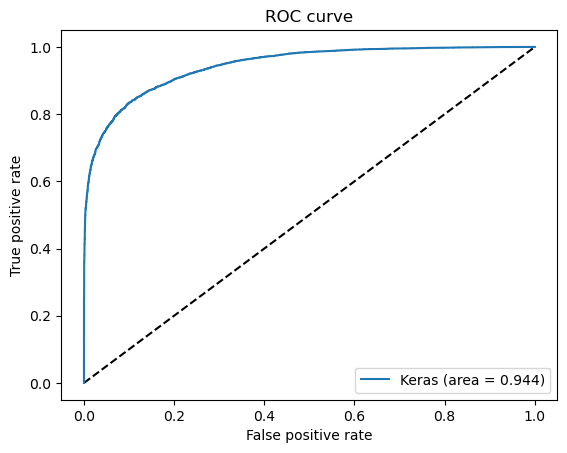

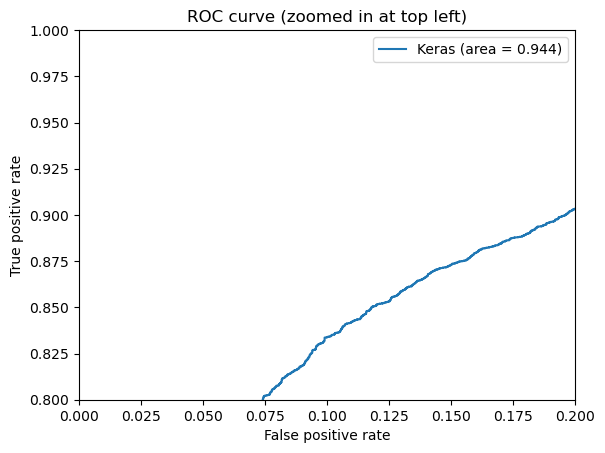

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()